# Import libraries

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import pywt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from collections import Counter

# Prepare Dataframe

In [2]:
# Read the CSV file
df = pd.read_csv('export-token-0x16ca471ae755f8a2cd4ec315a4a7439dcfebe54c.csv')

# Convert Quantity to numeric, removing commas
df['Quantity'] = df['Quantity'].str.replace(',', '').astype(float)

# Replace Method based on conditions
df.loc[(df['From'] == 'WETHContract') & (df['Method'] == '-'), 'Method'] = 'UniSwapEthforNexF'
df.loc[(df['To'] == 'WETHContract') & (df['Method'] == '-'), 'Method'] = 'BoughtNexFwithEth'

# Display the first few rows to verify changes
print(df.head())

# Save the modified DataFrame back to a CSV file
df.to_csv('modified_file.csv', index=False)

                                    Transaction Hash   Blockno  UnixTimestamp  \
0  0xaec22ba3e2c78b914ba3757b90021696616e146e676c...  19978224     1717018475   
1  0xc689a2b62e424824bab61c59ab29139a0c828d2a97f4...  19978387     1717020443   
2  0xd84f6021756ae652bd5b87e49e62fdfde8a708077773...  19978519     1717022027   
3  0x3b4d662428eec5ed98e1a4f96785b3ca9c03b72c71eb...  19978519     1717022027   
4  0xf1b289465164bb65889657cb8867dabad8612a84c1af...  19978519     1717022027   

        DateTime (UTC)                                        From  \
0  2024-05-29 21:34:35  0x0000000000000000000000000000000000000000   
1  2024-05-29 22:07:23  0x72ad95c3b65a0da6826b336c104a929d1e676bf3   
2  2024-05-29 22:33:47                                WETHContract   
3  2024-05-29 22:33:47                                WETHContract   
4  2024-05-29 22:33:47                                WETHContract   

                                           To      Quantity             Method  
0  0x72ad95

# Create Addresses DF and encode methods

In [3]:
contract_address = 'WETHContract'

# Create a new DataFrame to store address statistics
addresses = pd.DataFrame(columns=['Address', 'NetAmount', 'Interactions', 'Method_encoded', 'First_Interaction', 'Last_Interaction'])

# Function to update address statistics
def update_address_stats(address, amount, encoded_method, timestamp):
    if address not in addresses['Address'].values:
        addresses.loc[len(addresses)] = [address, 0, 0, defaultdict(int), timestamp, timestamp]
    
    idx = addresses.index[addresses['Address'] == address][0]
    addresses.at[idx, 'NetAmount'] += amount
    addresses.at[idx, 'Interactions'] += 1
    addresses.at[idx, 'Method_encoded'][encoded_method] += 1
    addresses.at[idx, 'First_Interaction'] = min(addresses.at[idx, 'First_Interaction'], timestamp)
    addresses.at[idx, 'Last_Interaction'] = max(addresses.at[idx, 'Last_Interaction'], timestamp)

# Encode 'Method' strings
method_encoding = {method: i for i, method in enumerate(df['Method'].unique())}
df['EncodedMethod'] = df['Method'].map(method_encoding)

# Analyze each transaction
for _, row in df.iterrows():
    if row['From'] != contract_address:
        update_address_stats(row['From'], -row['Quantity'], row['EncodedMethod'], row['UnixTimestamp'])
    
    if row['To'] != contract_address:
        update_address_stats(row['To'], row['Quantity'], row['EncodedMethod'], row['UnixTimestamp'])

# Convert 'Method_encoded' to a more readable format
addresses['Method_encoded'] = addresses['Method_encoded'].apply(lambda x: dict(x))

# Convert Unix timestamps to datetime
addresses['First_Interaction'] = pd.to_datetime(addresses['First_Interaction'], unit='s')
addresses['Last_Interaction'] = pd.to_datetime(addresses['Last_Interaction'], unit='s')



/var/folders/hz/gl_p4vf121z5m9m47w6fc7980000gn/T/ipykernel_4535/501003087.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '89108546.2016248' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  addresses.at[idx, 'NetAmount'] += amount


# Statistics


Statistical Summary:
Total Addresses: 647
Total NetAmount: -3979884068.6822815
Average NetAmount: -6151289.13243011
Total Interactions: 3010
Average Interactions: 4.652241112828439
Unique Methods: 22
Average Interaction Duration: 5 days 01:06:42.584234930
Median Interaction Duration: 0 days 00:10:48

Daily Transaction Summary:
count     113.000000
mean       23.008850
std       119.028695
min         0.000000
25%         0.000000
50%         0.000000
75%        24.000000
max      1257.000000
dtype: float64

Daily Net Amount Summary:
count    1.130000e+02
mean     2.018153e+10
std      3.948967e+10
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.900216e+10
max      2.483844e+11
Name: Quantity, dtype: float64


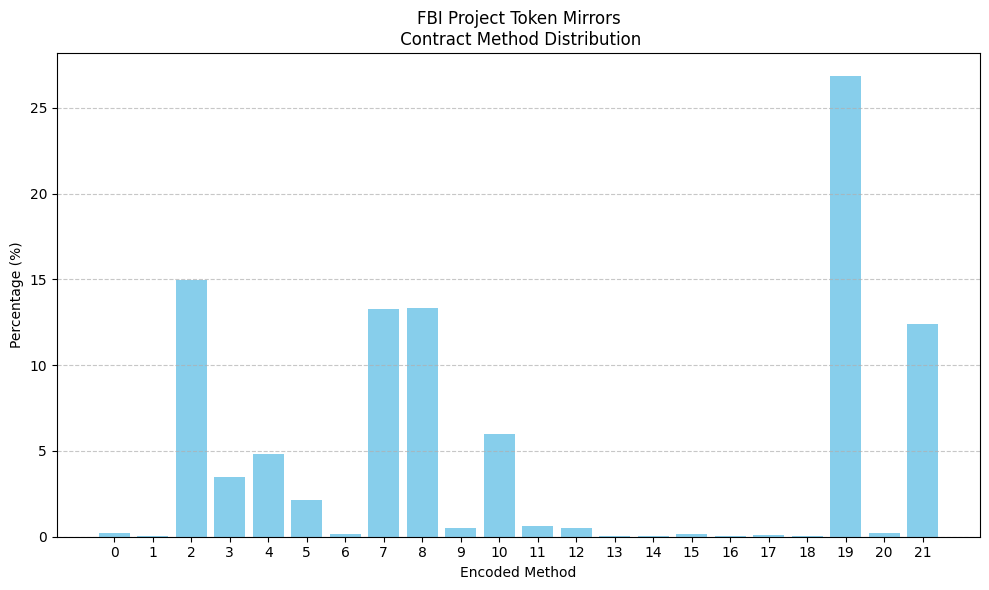

In [4]:
# Calculate interaction duration
addresses['Interaction_Duration'] = addresses['Last_Interaction'] - addresses['First_Interaction']

# Statistical summary of the addresses DataFrame
summary = {
    'Total Addresses': len(addresses),
    'Total NetAmount': addresses['NetAmount'].sum(),
    'Average NetAmount': addresses['NetAmount'].mean(),
    'Total Interactions': addresses['Interactions'].sum(),
    'Average Interactions': addresses['Interactions'].mean(),
    'Unique Methods': len(method_encoding),
    'Average Interaction Duration': addresses['Interaction_Duration'].mean(),
    'Median Interaction Duration': addresses['Interaction_Duration'].median(),
}

print("\nStatistical Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

# Method distribution analysis
method_distribution = defaultdict(int)
for methods in addresses['Method_encoded']:
    for method, count in methods.items():
        method_distribution[method] += count

total_method_calls = sum(method_distribution.values())
method_distribution_percentage = {method: (count / total_method_calls) * 100 for method, count in method_distribution.items()}

# Create a bar plot for method distribution
methods = list(method_distribution_percentage.keys())
percentages = list(method_distribution_percentage.values())

plt.figure(figsize=(10, 6))
plt.bar(methods, percentages, color='skyblue')
plt.xlabel('Encoded Method')
plt.ylabel('Percentage (%)')
plt.title('FBI Project Token Mirrors\n Contract Method Distribution')
plt.xticks(methods)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(f'contract_methods_distribution.png', dpi=300, bbox_inches='tight')


# Time series analysis
df['Timestamp'] = pd.to_datetime(df['UnixTimestamp'], unit='s')
df.set_index('Timestamp', inplace=True)

# Daily transaction count
daily_transactions = df.resample('D').size()

# Daily net amount
daily_net_amount = df.resample('D')['Quantity'].sum()

print("\nDaily Transaction Summary:")
print(daily_transactions.describe())

print("\nDaily Net Amount Summary:")
print(daily_net_amount.describe())

# Optional: Save the results to CSV files
addresses.to_csv('address_statistics.csv', index=False)
pd.DataFrame(summary, index=[0]).to_csv('statistical_summary.csv', index=False)
pd.DataFrame(method_distribution_percentage, index=[0]).to_csv('method_distribution.csv')
daily_transactions.to_csv('daily_transactions.csv')
daily_net_amount.to_csv('daily_net_amount.csv')

# Perform Wavelet analysis

In [5]:
# Convert Unix timestamp to datetime
df['UnixTimestamp'] = pd.to_datetime(df['UnixTimestamp'], unit='s')

# Perform wavelet analysis
quantity_series = df['Quantity'].values
time_series = df['UnixTimestamp'].values
wavelet = 'db4'  # Daubechies 4 wavelet
max_level = pywt.dwt_max_level(len(quantity_series), pywt.Wavelet(wavelet).dec_len)
coeffs = pywt.wavedec(quantity_series, wavelet, level=max_level)

# Calculate summary statistics across all levels
summary_stats = {
    'Mean': np.mean([np.mean(coeff) for coeff in coeffs]),
    'Median': np.median([np.median(coeff) for coeff in coeffs]),
    'Std Dev': np.mean([np.std(coeff) for coeff in coeffs]),
    'Skewness': np.mean([stats.skew(coeff) for coeff in coeffs]),
    'Kurtosis': np.mean([stats.kurtosis(coeff) for coeff in coeffs]),
    'Max Absolute Value': np.max([np.max(np.abs(coeff)) for coeff in coeffs]),
    'Total Energy': np.sum([np.sum(np.abs(coeff)**2) for coeff in coeffs])
}

# Visualize all frequency components with log scale
plt.figure(figsize=(20, 10))
ax = plt.gca()
colors = plt.cm.rainbow(np.linspace(0, 1, len(coeffs)))

for i, (coeff, color) in enumerate(zip(coeffs, colors)):
    # Interpolate coefficients to match original time series length
    coeff_interp = np.interp(np.linspace(0, 1, len(time_series)), 
                             np.linspace(0, 1, len(coeff)), coeff)
    ax.plot(time_series, coeff_interp, color=color, alpha=0.7, 
            label=f'Level {i}')

ax.set_title('FBI Operation Token Mirrors\nWavelet Decomposition of Token Quantity Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Coefficient Value')

# Create a text box with summary statistics and explanation
stats_text = "Wavelet Analysis:\n\n"

stats_text += "1. Each line color represents a different frequency range\n"
stats_text += "2. Lower levels show high-frequency details\n"
stats_text += "3. Higher levels show low-frequency approximations\n"
stats_text += "4. Coefficients indicate the strength of each frequency component\n"
stats_text += "5. Patterns across levels reveal multi-scale structure in the data"

# Add the statistics text box to the top right, below the legend
plt.text(0.1, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Save the figure with an informative title
plt.savefig(f'wavelet_decomposition_{wavelet}_level{max_level}.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"Wavelet decomposition plot saved as 'wavelet_decomposition_{wavelet}_level{max_level}.png'")

# Print wavelet statistics to console
print("\nWavelet Analysis Statistics:")
for stat, value in summary_stats.items():
    print(f"  {stat}: {value:.4f}")

Wavelet decomposition plot saved as 'wavelet_decomposition_db4_level8.png'

Wavelet Analysis Statistics:
  Mean: 21493653078.8659
  Median: 0.0000
  Std Dev: 36160940177.0763
  Skewness: -0.0403
  Kurtosis: 69.0671
  Max Absolute Value: 518528559504.5222
  Total Energy: 1400922230413546773020672.0000


# Distribution of Wavelet Coefficients

In [6]:
# Visualize distribution of coefficients with log scale
plt.figure(figsize=(12, 6))
for i, coeff in enumerate(coeffs):
    plt.hist(coeff, bins=30, alpha=0.5, label=f'Level {i}')
plt.title('FBI Operation Token Mirrors\nDistribution of Wavelet Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for y-axis
plt.legend()
plt.savefig('wavelet_coefficient_distribution_log_scale.png')
plt.close()

# Create an interactive visualization of the transaction interactions with the contract

In [7]:
# Encode 'Method' column in the original DataFrame
le = LabelEncoder()
df['Method_encoded'] = le.fit_transform(df['Method'])

# Create a new DataFrame to store address statistics
addresses = pd.DataFrame(columns=['Address', 'NetAmount', 'Interactions', 'Method_encoded'])

# Function to update address statistics
def update_address_stats(address, amount, encoded_method):
    if address not in addresses['Address'].values:
        addresses.loc[len(addresses)] = [address, 0, 0, []]
    
    idx = addresses.index[addresses['Address'] == address][0]
    addresses.at[idx, 'NetAmount'] += amount
    addresses.at[idx, 'Interactions'] += 1
    addresses.at[idx, 'Method_encoded'].append(encoded_method)

# Analyze each transaction
contract_address = 'WETHContract'
for _, row in df.iterrows():
    if row['From'] != contract_address:
        update_address_stats(row['From'], -row['Quantity'], row['Method_encoded'])
    
    if row['To'] != contract_address:
        update_address_stats(row['To'], row['Quantity'], row['Method_encoded'])

# Convert Method_encoded lists to a single representative value (e.g., most frequent)
addresses['Method_encoded'] = addresses['Method_encoded'].apply(lambda x: max(set(x), key=x.count) if x else np.nan)

# Create the interactive scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.sign(addresses['NetAmount']) * np.log1p(abs(addresses['NetAmount'])),
    y=np.sign(addresses['Interactions']) * np.log1p(abs(addresses['Interactions'])),
    mode='markers',
    marker=dict(
        size=np.log1p(abs(addresses['NetAmount'])) * 1.2,
        color=addresses['Method_encoded'],
        colorscale='Viridis',
        colorbar=dict(title='Method'),
        showscale=True
    ),
    customdata=addresses['Address'],  # Pass addresses as custom data for callback
    text=[f"Address: {addr}<br>"
          f"Interactions: {inter:,}<br>"
          f"Net Amount: {net:.2f}<br>"
          f"Encoded Method: {method}"
          for addr, inter, net, method in addresses[['Address', 'Interactions', 'NetAmount', 'Method_encoded']].itertuples(index=False)],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title="FBI Operation Token Mirrors<br>Address Interactions vs Net Amount (Log Scale)",
    xaxis_title="Log(Net Amount of NexF Tokens)",
    yaxis_title="Log(Number of Interactions) with<br>NexF Contract @ 0x16ca471ae755f8a2cd4ec315a4a7439dcfebe54c",
    xaxis=dict(zeroline=False),
    yaxis=dict(zeroline=False),
    hovermode='closest',
    width=1000,
    height=800
)

# Save the interactive plot
fig.write_html("address_interactions.html", full_html=False)

print("\nInteractive Address Interactions vs Net Amount Visualization saved as 'address_interactions.html'")

# Add JavaScript for clipboard functionality
html_content = """
<div id="myDiv"></div>
<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
<script>
var myPlot = document.getElementById('myDiv');
Plotly.newPlot(myPlot, %s);

myPlot.on('plotly_click', function(data){
    var address = data.points[0].customdata; // Access customdata directly
    navigator.clipboard.writeText(address).then(function() {
        alert('Address copied to clipboard: ' + address);
    }, function(err) {
        console.error('Could not copy text: ', err);
    });
});
</script>
""" % fig.to_json()

with open("address_interactions.html", "w") as f:
    f.write(html_content)

print("HTML file with clipboard functionality has been created.")

/var/folders/hz/gl_p4vf121z5m9m47w6fc7980000gn/T/ipykernel_4535/768293986.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '89108546.2016248' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  addresses.at[idx, 'NetAmount'] += amount



Interactive Address Interactions vs Net Amount Visualization saved as 'address_interactions.html'
HTML file with clipboard functionality has been created.


In [ ]:
# Step 3: Convert Method into categorical data
df['Method'] = pd.Categorical(df['Method'])

# Step 4: Analyze To and From data
to_from_pairs = list(zip(df['To'], df['From']))
pair_counts = Counter(to_from_pairs)

# Create a mathematical model of the categorical data
total_transactions = len(to_from_pairs)
pair_distribution = {pair: count / total_transactions for pair, count in pair_counts.items()}

# Sort pairs by frequency
sorted_pairs = sorted(pair_distribution.items(), key=lambda x: x[1], reverse=True)

# Print results
print(f"Total number of unique (To, From) pairs: {len(pair_counts)}")
print("\nTop 10 most frequent (To, From) pairs and their distribution:")
for pair, dist in sorted_pairs[:10]:
    print(f"Pair: {pair}, Distribution: {dist:.4f}, Count: {pair_counts[pair]}")

# Visualize distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_pairs)), [dist for _, dist in sorted_pairs])
plt.title('FBI Operation Token Mirror\nDistribution of (Sender, Receiver) Pairs')
plt.xlabel('Pair Index (sorted by frequency)')
plt.ylabel('Distribution')
plt.savefig('pair_distribution.png')
plt.close()

Total number of unique (To, From) pairs: 1449

Top 10 most frequent (To, From) pairs and their distribution:
Pair: ('0xe18159438734295bf8611df8ae91323b992a2bc4', 'WETHContract'), Distribution: 0.0162, Count: 42
Pair: ('WETHContract', '0x289d4ae72a64ff07cb3d80d5520b55ec04ec2aa9'), Distribution: 0.0158, Count: 41
Pair: ('0x289d4ae72a64ff07cb3d80d5520b55ec04ec2aa9', 'WETHContract'), Distribution: 0.0154, Count: 40
Pair: ('WETHContract', '0xe18159438734295bf8611df8ae91323b992a2bc4'), Distribution: 0.0135, Count: 35
Pair: ('0x1127db41c0dd1ca4a19cc47608bcb111c409f120', 'WETHContract'), Distribution: 0.0119, Count: 31
Pair: ('WETHContract', '0x1127db41c0dd1ca4a19cc47608bcb111c409f120'), Distribution: 0.0115, Count: 30
Pair: ('0x8a5d8700dd19488d964d202e87b0cc85704054db', 'WETHContract'), Distribution: 0.0112, Count: 29
Pair: ('WETHContract', '0x8a5d8700dd19488d964d202e87b0cc85704054db'), Distribution: 0.0112, Count: 29
Pair: ('WETHContract', '0x76999aed261fc44d04acf027635b96f23eff444e'), Distr